In [1]:
# 读取数据
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
% matplotlib inline

pdData = pd.read_csv(
    "E:\Workspace\jupyter_notebook\\notebook_idata_lesson01\Logistic-Regression\\LogiReg_data.txt",
    header=None,
    names=["Exam_1", "Exam_2", "Admitted"]
)
print(pdData.shape)
pdData[:5]


(100, 3)


,Exam_1,Exam_2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Text(0,0.5,'Exam_2 score')

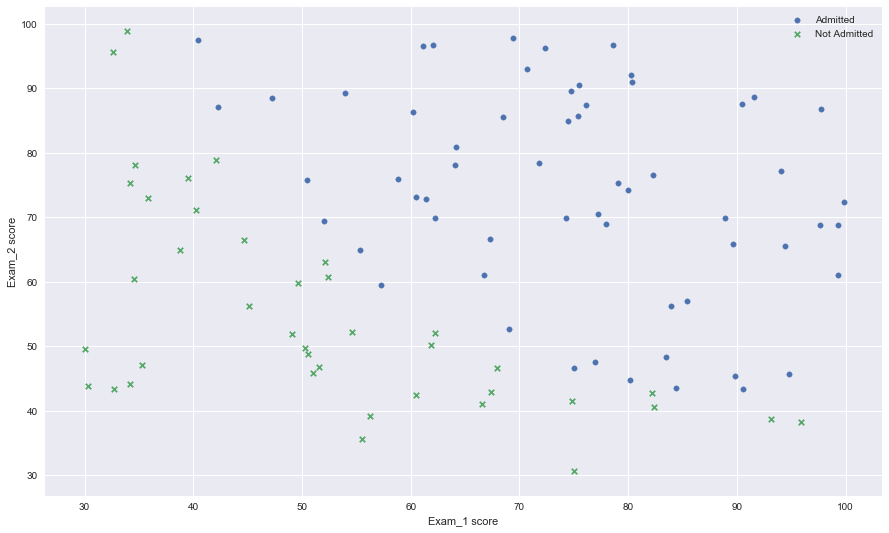

In [2]:
# 画出数据的分布
positive = pdData[pdData["Admitted"] == 1]
negative = pdData[pdData["Admitted"] == 0]

sns.set()
fig, ax = plt.subplots(figsize=(15, 9))
ax.scatter(positive["Exam_1"], positive["Exam_2"], s=30, marker="o", label="Admitted")
ax.scatter(negative["Exam_1"], negative["Exam_2"], s=30, marker="x", label="Not Admitted")
ax.legend()
ax.set_xlabel("Exam_1 score")
ax.set_ylabel("Exam_2 score")


目标：建立分类器(求解出三个参数)
设定阈值，根据阈值判断录取结果

要完成的模块
 - sigmoid:映射到概率的模块
 - model:返回预测结果值
 - cost:根据参数计算损失
 - gradient:计算每个参数的梯度方向
 - descent:进行参数更新
 - accuracy:计算精度

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))  # np.exp就是计算e的多少次幂，注意这里是-z


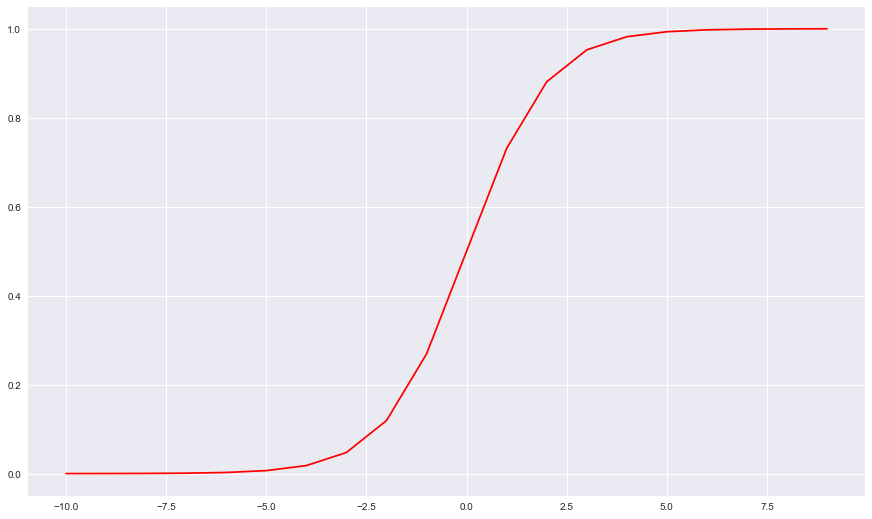

In [4]:
# 查看sigmoid的取值范围
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(nums, sigmoid(nums), "r")


In [5]:
# 返回预测值
def model(x, theta):
    return sigmoid(np.dot(x, theta.T))


In [6]:
# 在第0列的位置插入一列θ0，值为1以便计算
if pdData.columns.values[0] != "Ones":
    pdData.insert(0, "Ones", 1)

orig_data = pdData.as_matrix()
print("orig_data.shape=", orig_data.shape)
cols = orig_data.shape[1]
print("cols=", cols)
# 特征值
x = orig_data[:, 0:cols - 1]  # 所有的行，然后0:cols-1列
print("x.shape=", x.shape) 
print("x=", x[:5])
y = orig_data[:, cols - 1:cols]
print("y.shape=", y.shape)

# θ占位
theta = np.zeros([1, 3])


orig_data.shape= (100, 4)
cols= 4
x.shape= (100, 3)
x= [[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]]
y.shape= (100, 1)


$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [7]:
# 损失函数
def cost(x, y, theta):
    # 将函数看成两部分
    left = np.multiply(-y, np.log(model(x, theta)))
    right = np.multiply(1 - y, np.log(1 - model(x, theta)))
    return np.sum(left - right) / len(x)


cost(x, y, theta)


0.6931471805599453

计算梯度

$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$

In [8]:
def gradient(x, y, theta):
    grad = np.zeros(theta.shape)
    # 误差
    error = (model(x, theta) - y).ravel()  #数组拉直
    for j in range(len(theta.ravel())):
        term = np.multiply(error, x[:, j])
        grad[0, j] = np.sum(term) / len(x)
    return grad


In [9]:
# 比较三种梯度下降
STOP_ITER = 0  #根据迭代次数
STOP_COST = 1  #根据损失的差异
STOP_GRAD = 2  #根据梯度

# 设置阈值和停止方式
def stopCriterion(type, value, threshold):
    if type == STOP_ITER:
        return value > threshold
    elif type == STOP_COST:
        return abs(value[-1] - value[-2]) < threshold
    elif type == STOP_GRAD:
        return np.linalg.norm(value) < threshold


In [10]:
import numpy.random

# 洗牌，打乱样本的顺序
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    x = data[:, 0:cols - 1]
    y = data[:, cols - 1:]
    return x, y


In [17]:
# 梯度下降求解
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    # 初始值
    init_time = time.time()
    i = 0  #1迭代次数
    k = 0  #batch
    x, y = shuffleData(data)
    grad = np.zeros(theta.shape)
    costs = [cost(x, y, theta)]

    while True:
        grad = gradient(x[k:k + batchSize], y[k:k + batchSize], theta)
        k += batchSize
        if k >= n:
            k = 0
            x, y = shuffleData(data)
        theta = theta - alpha * grad
        costs.append(cost(x, y, theta))
        i += 1

        if stopType == STOP_ITER:
            value = i
        elif stopType == STOP_COST:
            value = costs
        elif stopType == STOP_GRAD:
            value = grad
        if stopCriterion(stopType, value, thresh): break

    return theta, i - 1, costs, grad, time.time() - init_time


In [18]:
# 运行
def runExpe(data, thata, batchSize, stopType, thresh, alpha):
    theta, iter, costs, grad, dur = descent(data, thata, batchSize, stopType, thresh, alpha)

    name = "Original" if (data[:, 1] > 2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize == n:
        strDescType = "Gradient"
    elif batchSize == 1:
        strDescType = "Stochastic"
    else:
        strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER:
        strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST:
        strStop = "costs change < {}".format(thresh)
    else:
        strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta


***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 1.16s


array([[-0.00027127,  0.00705232,  0.00376711]])

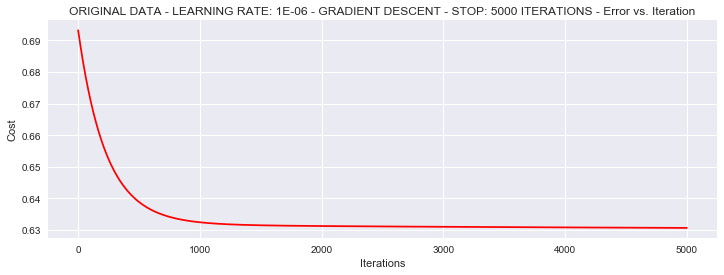

In [20]:
# 设置迭代次数
n = 100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)
